## Instructions

You are asked to complete the following files:
* **pruned_layers.py**, which contains the pruning of DNNs to reduce the storage of insignificant weight parameters with 2 methods: pruning by percentage and prune by standard deviation.
* **train_util.py**, which includes the training process of DNNs with pruned connections.
* **quantize.py**, which applies the quantization (weight sharing) part on the DNN to reduce the storage of weight parameters.
* **huffman_coding.py**, which applies the Huffman coding onto the weight of DNNs to further compress the weight size.

You are asked to submit the following files:
* **net_before_pruning.pt**, which is the set of weight parameters before applying pruning on DNN weight parameters.
* **net_after_pruning.pt**, which is the set of weight paramters after applying pruning on DNN weight parameters.
* **net_after_quantization.pt**, which is the set of weight parameters after applying quantization (weight sharing) on DNN weight parameters.
* **codebook_resnet20.npy**, which is the quantization codebook of each layer after applying quantization (weight sharing).
* **huffman_encoding.npy**, which is the encoding map of each item within the quantization codebook in the whole DNN architecture.
* **huffman_freq.npy**, which is the frequency map of each item within the quantization codebook in the whole DNN. 

To ensure fair grading policy, we fix the choice of model to ResNet-20. You may check the implementation in **resnet20.py** for more details.

In [1]:
from resnet20 import ResNetCIFAR
from train_util import train, finetune_after_prune, test
from quantize import quantize_whole_model
from huffman_coding import huffman_coding
from summary import summary
import torch
import numpy as np
from prune import prune

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Full-precision model training

In [2]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)

#Uncomment to load pretrained weights
net.load_state_dict(torch.load("net_before_pruning_best.pt"))
# Comment if you have loaded pretrained weights
#train(net, epochs=100, batch_size= 128, lr= 0.1, reg= 1e-4)

<All keys matched successfully>

In [5]:
# Load the best weight paramters
net.load_state_dict(torch.load("net_before_pruning_best.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3441, Test accuracy=0.9140


0.914

In [4]:
print("-----Summary before pruning-----")
summary(net)
print("-------------------------------")

-----Summary before pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		388			0.550926
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	4608		2274			0.506510
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	2304		1290			0.440104
8		BatchNorm	N/A		N/A			N/A
9		Convolutional	512		257			0.498047
10		BatchNorm	N/A		N/A			N/A
11		ReLU		N/A		N/A			N/A
12		Convolutional	2304		1292			0.439236
13		BatchNorm	N/A		N/A			N/A
14		ReLU		N/A		N/A			N/A
15		Convolutional	2304		1317			0.428385
16		BatchNorm	N/A		N/A			N/A
17		ReLU		N/A		N/A			N/A
18		Convolutional	2304		1312			0.430556
19		BatchNorm	N/A		N/A			N/A
20		ReLU		N/A		N/A			N/A
21		Convolutional	2304		1328			0.423611
22		BatchNorm	N/A		N/A			N/A
23		ReLU		N/A		N/A			N/A
24		Convolutional	4608		2578			0.440538
25		BatchNorm	N/A		N/A			N/A
26		ReLU		N/A		N/A			N/A
27		Convolutional	9216		5312			0.423611
28		BatchNorm	N/A		N/A			N/A
29		Convolutional	512		289			0.43

### Pruning & Finetune with pruned connections

In [5]:
s_list = [0, 0.25, 0.5, 1]
s_sparsity = []
s_acc = []

for i in s_list:
    net = ResNetCIFAR(num_layers = 20)
    net = net.to(device)
    net.load_state_dict(torch.load("net_before_pruning_best.pt"))

    # Test accuracy before fine-tuning
    prune(net, method='std', q=0, s=i)
    s_sparsity.append(summary(net, printme = False))
    s_acc.append(test(net))
    torch.save(net.state_dict(), f"net_after_pruning_std{str(i)}.pt")

Total nonzero parameters: 274144
Total parameters: 274144
Total sparsity: 0.000000
Files already downloaded and verified
Test Loss=0.3441, Test accuracy=0.9140
Total nonzero parameters: 217855
Total parameters: 274144
Total sparsity: 0.205326
Files already downloaded and verified
Test Loss=0.3597, Test accuracy=0.9082
Total nonzero parameters: 165219
Total parameters: 274144
Total sparsity: 0.397328
Files already downloaded and verified
Test Loss=0.4783, Test accuracy=0.8748
Total nonzero parameters: 83582
Total parameters: 274144
Total sparsity: 0.695116
Files already downloaded and verified
Test Loss=1.8858, Test accuracy=0.4718


In [6]:
for i in range(4):
    s_sparsity[i] = np.round(s_sparsity[i],4)

print(f's: {s_list}\nSparsity: {s_sparsity}\nAccuracy:{s_acc}')

s: [0, 0.25, 0.5, 1]
Sparsity: [0.0, 0.2053, 0.3973, 0.6951]
Accuracy:[0.914, 0.9082, 0.8748, 0.4718]


In [ ]:
# Uncomment to load pretrained weights
net.load_state_dict(torch.load("net_after_pruning_percentage/net_after_pruning_percentage0.5.pt"))
# Comment if you have loaded pretrained weights
finetune_after_prune(net, epochs=20, batch_size=128, lr=0.001, reg=1e-4)

In [5]:
# Load the best weight paramters
net.load_state_dict(torch.load("net_after_pruning_retrain_std/net_after_pruning_retrain_std0.25.pt"))
retrain_acc = test(net)

Files already downloaded and verified
Test Loss=0.3521, Test accuracy=0.9136


In [10]:
print("-----Summary After pruning-----")
percent_files = ['net_after_pruning_retrain_percentage/net_after_pruning_retrain_percentage0.pt', 'net_after_pruning_retrain_percentage/net_after_pruning_retrain_percentage0.25.pt', 
         'net_after_pruning_retrain_percentage/net_after_pruning_retrain_percentage0.5.pt', 'net_after_pruning_retrain_percentage/net_after_pruning_retrain_percentage0.75.pt']

std_files = ['net_after_pruning_retrain_std/net_after_pruning_retrain_std0.pt', 'net_after_pruning_retrain_std/net_after_pruning_retrain_std0.25.pt', 
         'net_after_pruning_retrain_std/net_after_pruning_retrain_std0.5.pt', 'net_after_pruning_retrain_std/net_after_pruning_retrain_std1.pt']

s_sparsity = []
s_acc = []

for i in std_files:
    net = ResNetCIFAR(num_layers = 20)
    net = net.to(device)
    net.load_state_dict(torch.load(i))

    # Test accuracy before fine-tuning
    s_sparsity.append(summary(net, printme = False))
    s_acc.append(test(net))
print(f's: {s_list}\nSparsity: {s_sparsity}\nAccuracy:{s_acc}')
print("-------------------------------")

-----Summary After pruning-----
Total nonzero parameters: 274144
Total parameters: 274144
Total sparsity: 0.000000
Files already downloaded and verified
Test Loss=0.3492, Test accuracy=0.9140
Total nonzero parameters: 217855
Total parameters: 274144
Total sparsity: 0.205326
Files already downloaded and verified
Test Loss=0.3521, Test accuracy=0.9136
Total nonzero parameters: 165219
Total parameters: 274144
Total sparsity: 0.397328
Files already downloaded and verified
Test Loss=0.3476, Test accuracy=0.9110
Total nonzero parameters: 83582
Total parameters: 274144
Total sparsity: 0.695116
Files already downloaded and verified
Test Loss=0.3520, Test accuracy=0.8940
s: [0, 0.25, 0.5, 1]
Sparsity: [0.0, 0.20532639780553286, 0.3973276818022645, 0.6951164351581651]
Accuracy:[0.914, 0.9136, 0.911, 0.894]
-------------------------------


### Sparsity across channels check for structured/unstructured

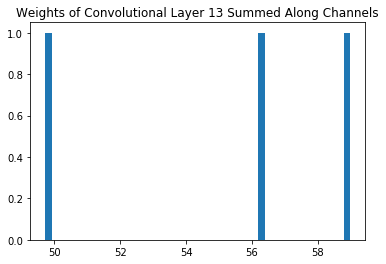

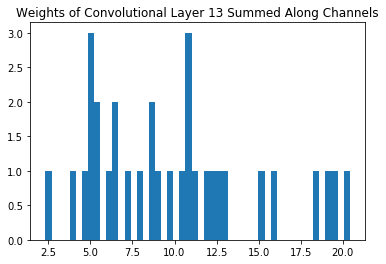

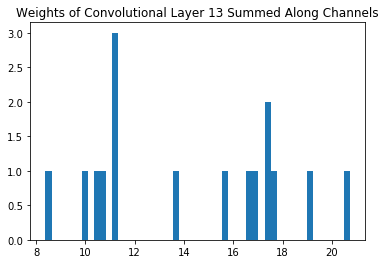

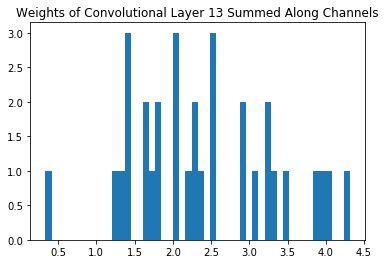

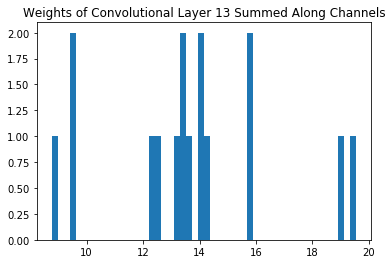

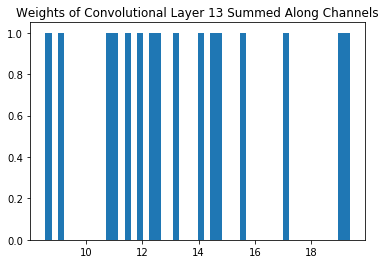

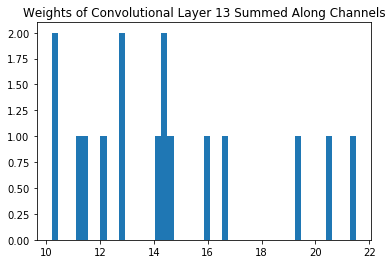

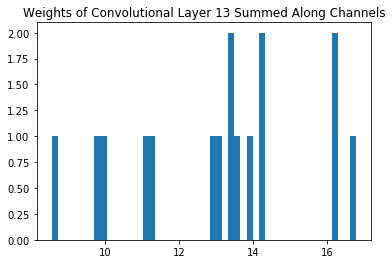

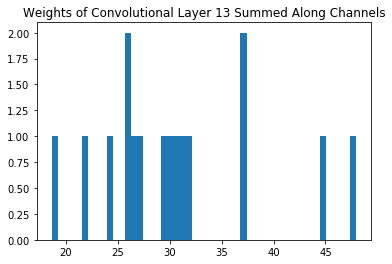

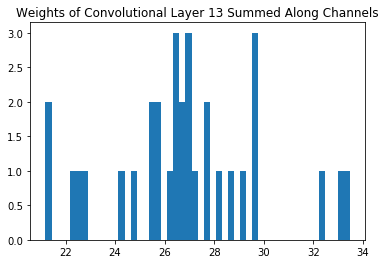

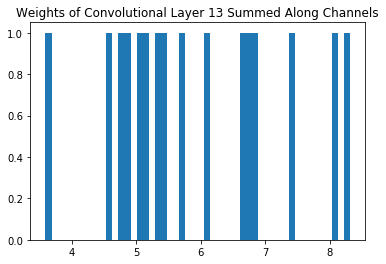

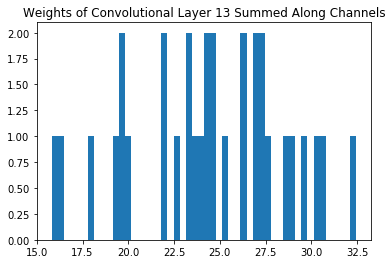

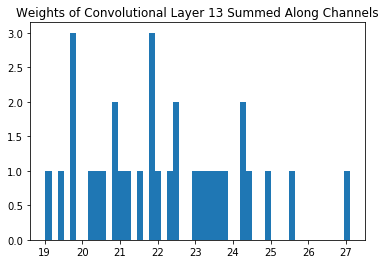

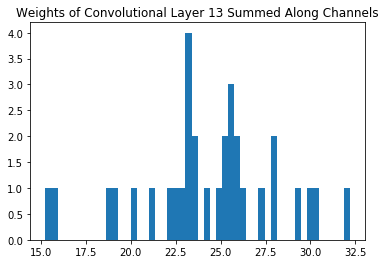

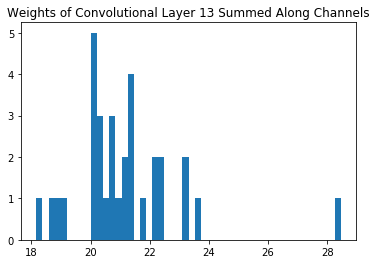

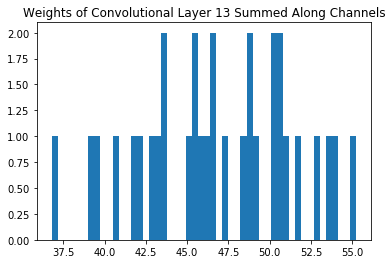

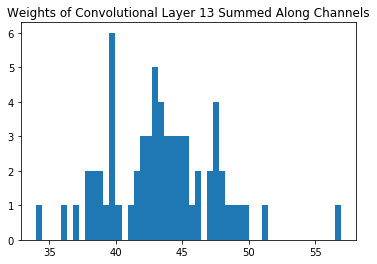

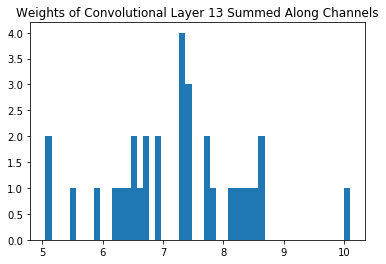

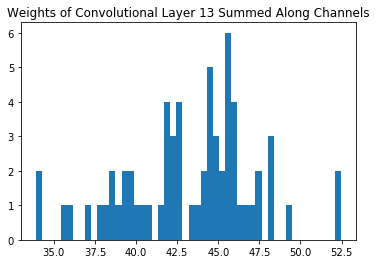

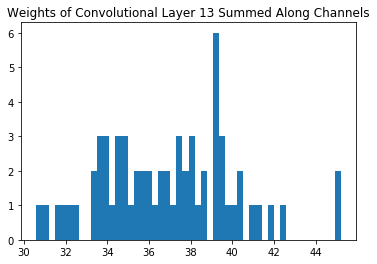

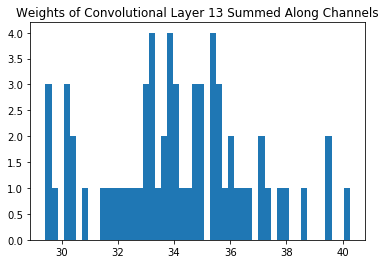

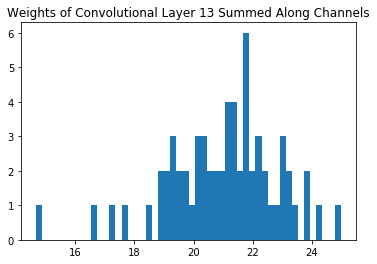

In [39]:
import matplotlib.pyplot as plt
from pruned_layers import *

net = ResNetCIFAR(num_layers=20)
net = net.to(device)
net.load_state_dict(torch.load('net_after_pruning_std/net_after_pruning_std0.25.pt'))

for name, param in net.named_modules():
    if isinstance(param, PrunedConv):
        weight = param.conv.weight.data.cpu().numpy()
        weight = np.abs(weight)
        # NCHW: so we are summing across channels
        weight_axis_comb = np.sum(weight, axis = (0,2,3))
        
        plt.hist(weight_axis_comb, bins =50)
        plt.title("Weights of Convolutional Layer 13 Summed Along Channels")
        plt.show()

### Quantization

In [8]:
net.load_state_dict(torch.load('net_after_pruning_retrain_std/net_after_pruning_retrain_std0.25.pt'))
centers = quantize_whole_model(net, bits=5)
np.save("codebook_resnet20.npy", centers)
torch.save(net.state_dict(), "net_after_quantization_5bit_linear.pt")

Complete 1 layers quantization...
Complete 2 layers quantization...
Complete 3 layers quantization...
Complete 4 layers quantization...
Complete 5 layers quantization...
Complete 6 layers quantization...
Complete 7 layers quantization...
Complete 8 layers quantization...
Complete 9 layers quantization...
Complete 10 layers quantization...
Complete 11 layers quantization...
Complete 12 layers quantization...
Complete 13 layers quantization...
Complete 14 layers quantization...
Complete 15 layers quantization...
Complete 16 layers quantization...
Complete 17 layers quantization...
Complete 18 layers quantization...
Complete 19 layers quantization...
Complete 20 layers quantization...
Complete 21 layers quantization...
Complete 22 layers quantization...
Complete 23 layers quantization...


In [4]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)
net.load_state_dict(torch.load("net_after_quantization_5bit_linear.pt"))

<All keys matched successfully>

In [5]:
test(net)

Files already downloaded and verified
Test Loss=0.3739, Test accuracy=0.9078


0.9078

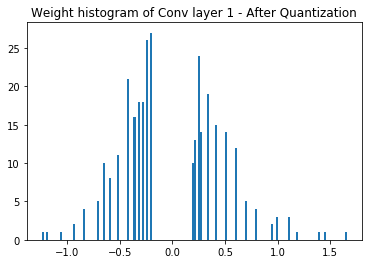

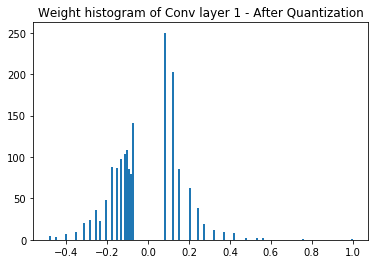

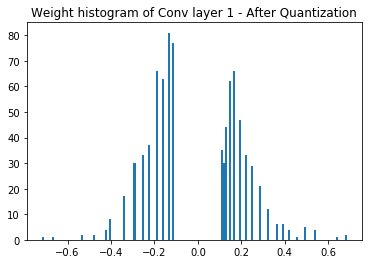

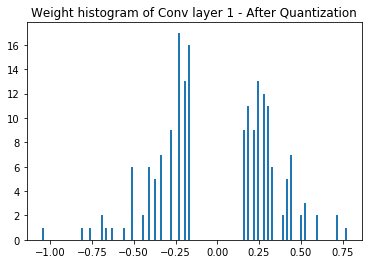

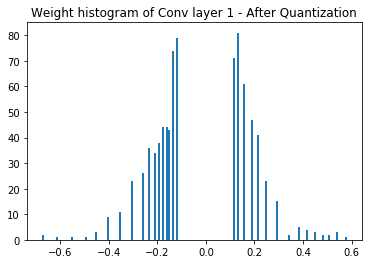

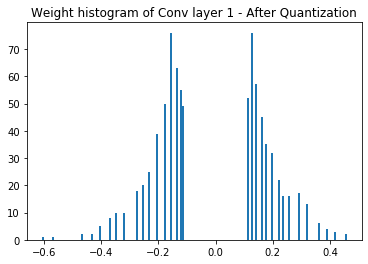

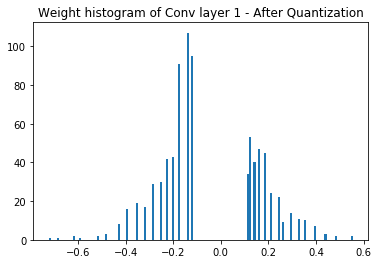

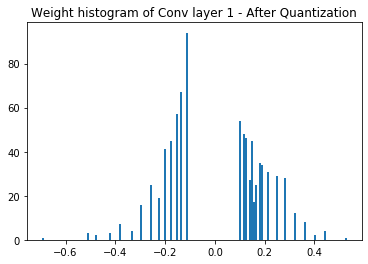

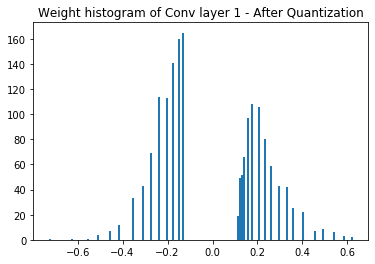

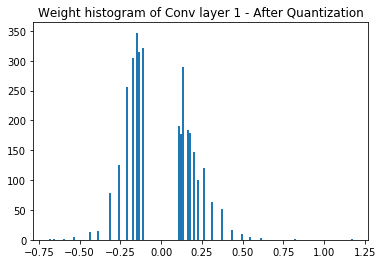

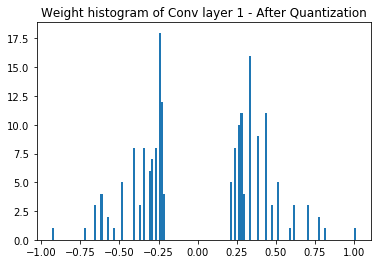

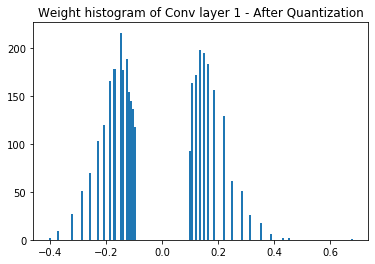

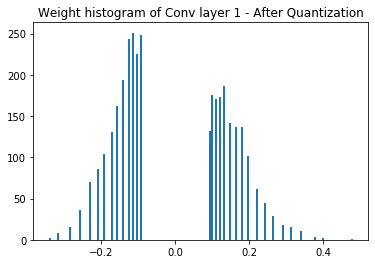

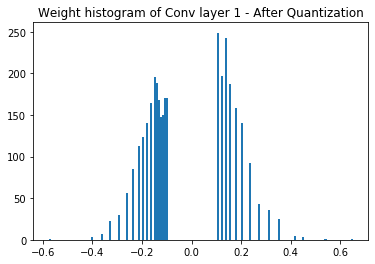

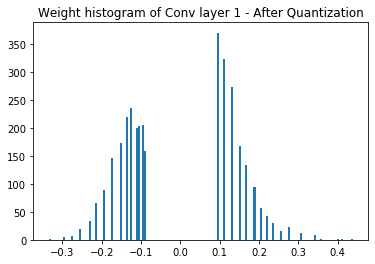

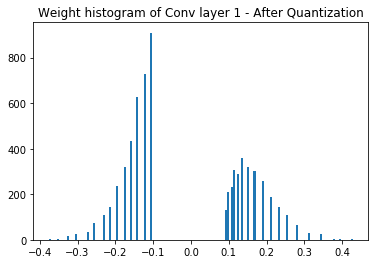

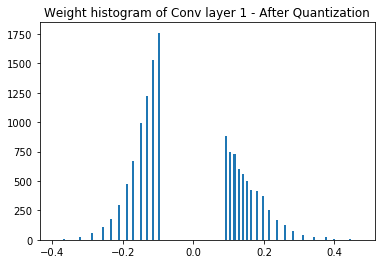

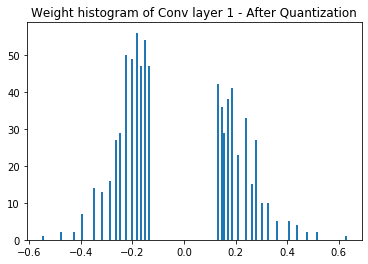

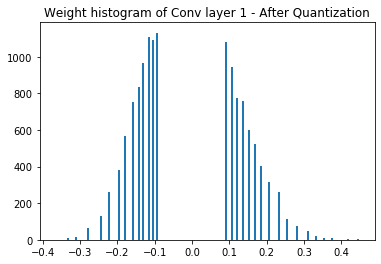

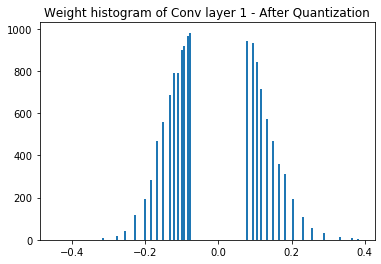

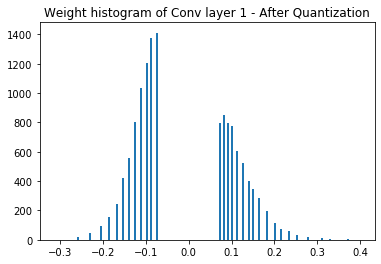

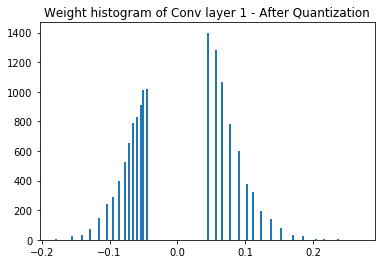

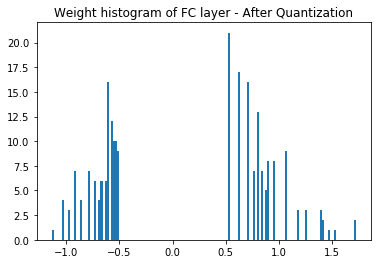

In [21]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)
net.load_state_dict(torch.load('net_after_quantization.pt'))

from pruned_layers import *
import matplotlib.pyplot as plt
for n, m in net.named_modules():
    if isinstance(m, PrunedConv):
        weight = m.conv.weight.data.cpu().numpy()
        
        # Remove zero weights
        non_zero_idx = np.nonzero(weight)
        weight = weight[non_zero_idx]
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=150)
        plt.title("Weight histogram of Conv layer 1 - After Quantization")
        plt.show()    
    
    elif isinstance(m, PruneLinear):
        weight = m.linear.weight.data.cpu().numpy()
        
        # Remove zero weights
        non_zero_idx = np.nonzero(weight)
        weight = weight[non_zero_idx]
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=150)
        plt.title("Weight histogram of FC layer - After Quantization")
        plt.show()

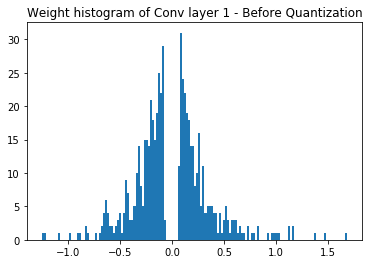

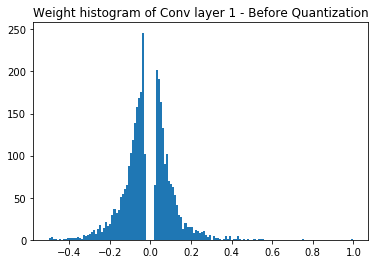

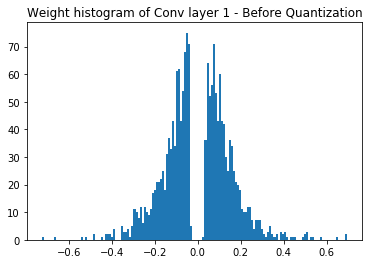

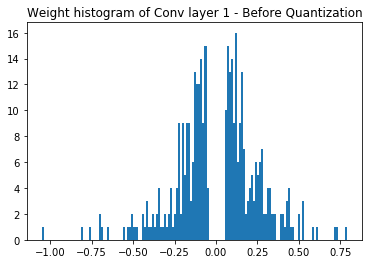

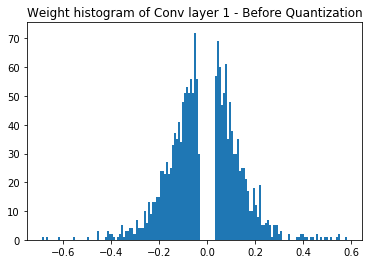

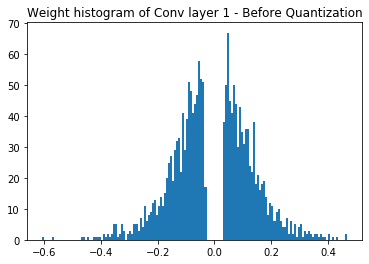

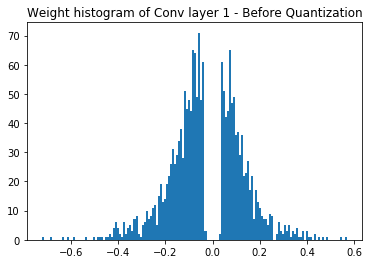

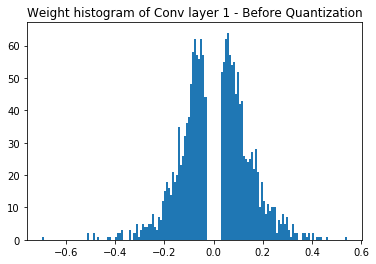

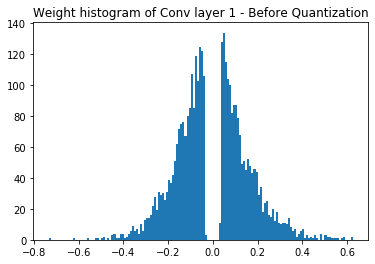

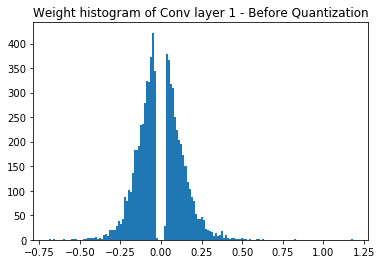

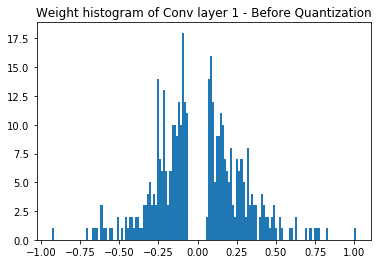

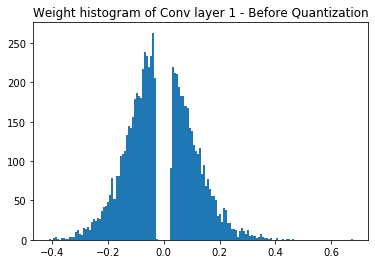

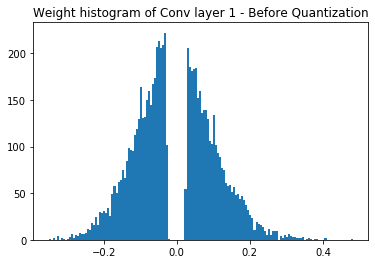

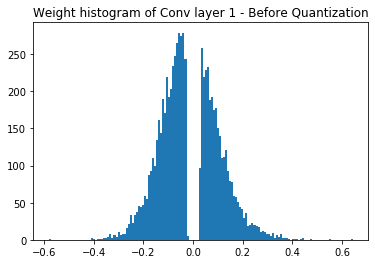

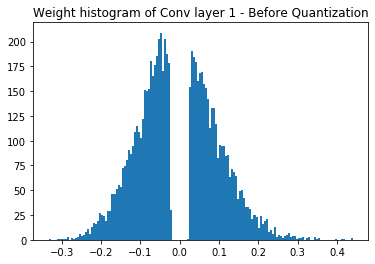

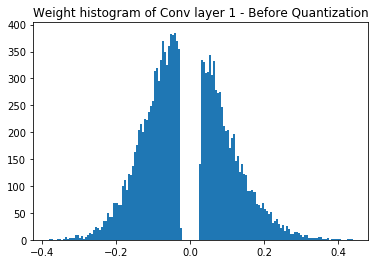

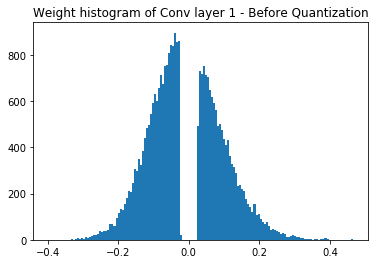

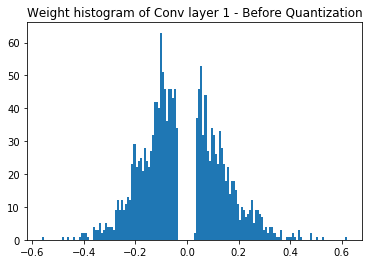

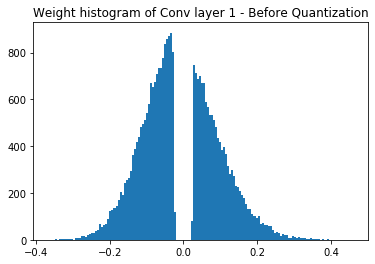

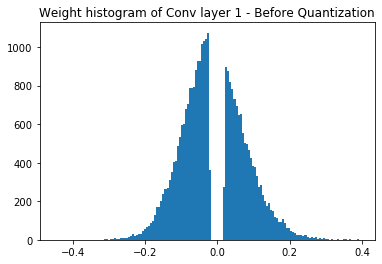

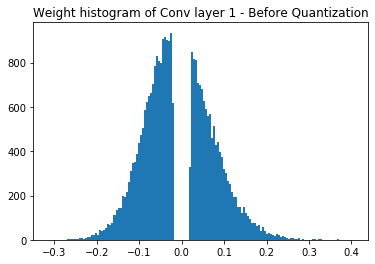

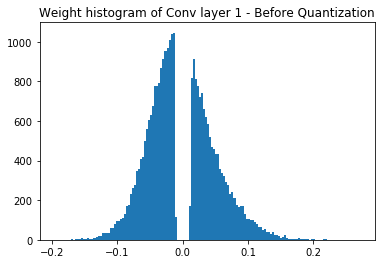

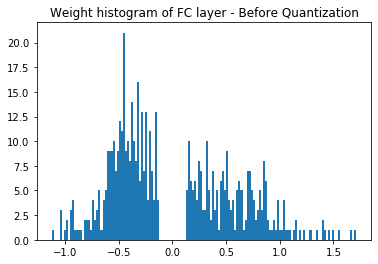

In [20]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)
net.load_state_dict(torch.load('net_after_pruning_retrain_std/net_after_pruning_retrain_std0.25.pt'))

from pruned_layers import *
import matplotlib.pyplot as plt

for n, m in net.named_modules():
    if isinstance(m, PrunedConv):
        weight = m.conv.weight.data.cpu().numpy()
        
        # Remove zero weights
        non_zero_idx = np.nonzero(weight)
        weight = weight[non_zero_idx]
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=150)
        plt.title("Weight histogram of Conv layer 1 - Before Quantization")
        plt.show()    
    
    elif isinstance(m, PruneLinear):
        weight = m.linear.weight.data.cpu().numpy()
        
        # Remove zero weights
        non_zero_idx = np.nonzero(weight)
        weight = weight[non_zero_idx]
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=150)
        plt.title("Weight histogram of FC layer - Before Quantization")
        plt.show()

### Huffman Coding

In [6]:
centers = np.load('codebook_resnet20.npy')

In [8]:
encoding_map, frequency_map, bit_list = huffman_coding(net, centers)
np.save("huffman_encoding", encoding_map)
np.save("huffman_freq", frequency_map)

Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 3.8976 bits
Complete 1 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.3116 bits
Complete 2 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.1402 bits
Complete 3 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.3056 bits
Complete 4 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.1382 bits
Complete 5 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.3405 bits
Complete 6 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Ave

In [12]:
total_sparisty, num_nz = summary(net)

Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		586			0.321759
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	4608		3331			0.277127
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	2304		1748			0.241319
8		BatchNorm	N/A		N/A			N/A
9		Convolutional	512		373			0.271484
10		BatchNorm	N/A		N/A			N/A
11		ReLU		N/A		N/A			N/A
12		Convolutional	2304		1765			0.233941
13		BatchNorm	N/A		N/A			N/A
14		ReLU		N/A		N/A			N/A
15		Convolutional	2304		1777			0.228733
16		BatchNorm	N/A		N/A			N/A
17		ReLU		N/A		N/A			N/A
18		Convolutional	2304		1752			0.239583
19		BatchNorm	N/A		N/A			N/A
20		ReLU		N/A		N/A			N/A
21		Convolutional	2304		1776			0.229167
22		BatchNorm	N/A		N/A			N/A
23		ReLU		N/A		N/A			N/A
24		Convolutional	4608		3533			0.233290
25		BatchNorm	N/A		N/A			N/A
26		ReLU		N/A		N/A			N/A
27		Convolutional	9216		7237			0.214735
28		BatchNorm	N/A		N/A			N/A
29		Convolutional	512		402			0.214844
30		BatchNorm	N/A		N/A			N/A

In [20]:
weighted_bits = np.array(bit_list) * np.array(num_nz)
weighted_bits.sum()/np.array(num_nz).sum()

4.287484794932409

# Lab 4: Model Compression

In [8]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)

#Uncomment to load pretrained weights
net.load_state_dict(torch.load("net_before_pruning_best.pt"))

<All keys matched successfully>

### Iterative Pruning

In [9]:
prune(net, method='percentage', q=.5, s=0)
print('pruned')
finetune_after_prune(net, epochs=10, batch_size=128, lr=0.001, reg=1e-4)
net.load_state_dict(torch.load("net_after_pruning.pt"))

prune(net, method='percentage', q=.6, s=0)
print('pruned')
finetune_after_prune(net, epochs=10, batch_size=128, lr=0.001, reg=1e-4)
net.load_state_dict(torch.load("net_after_pruning.pt"))

prune(net, method='percentage', q=.64, s=0)
print('pruned')
finetune_after_prune(net, epochs=10, batch_size=128, lr=0.001, reg=1e-4)


pruned
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=0.1184	acc=0.9591	1724.2 examples/second
[Step=100]	Loss=0.1147	acc=0.9598	1818.2 examples/second
[Step=150]	Loss=0.1134	acc=0.9603	1772.5 examples/second
[Step=200]	Loss=0.1114	acc=0.9605	1710.4 examples/second
[Step=250]	Loss=0.1078	acc=0.9616	1964.3 examples/second
[Step=300]	Loss=0.1049	acc=0.9625	1852.5 examples/second
[Step=350]	Loss=0.1041	acc=0.9627	1730.4 examples/second
Test Loss=0.3611, Test acc=0.9037
Saving...

Epoch: 1
[Step=400]	Loss=0.0963	acc=0.9661	919.3 examples/second
[Step=450]	Loss=0.0844	acc=0.9703	2056.0 examples/second
[Step=500]	Loss=0.0881	acc=0.9691	2077.2 examples/second
[Step=550]	Loss=0.0874	acc=0.9692	2154.1 examples/second
[Step=600]	Loss=0.0873	acc=0.9693	1992.6 examples/second
[Step=650]	Loss=0.0868	acc=0.9695	1782.1 examples/second
[Step=700]	Loss=0.0853	acc=0.9698	1775.1 examples/second
[Step=750]	Loss=0.0860	acc=0.9693	17

### Quantize

In [10]:
net.load_state_dict(torch.load('net_after_pruning.pt'))
centers = quantize_whole_model(net, bits=5)
np.save("codebook_resnet20.npy", centers)
torch.save(net.state_dict(), "net_after_quantization.pt")

Complete 1 layers quantization...
Complete 2 layers quantization...
Complete 3 layers quantization...
Complete 4 layers quantization...
Complete 5 layers quantization...
Complete 6 layers quantization...
Complete 7 layers quantization...
Complete 8 layers quantization...
Complete 9 layers quantization...
Complete 10 layers quantization...
Complete 11 layers quantization...
Complete 12 layers quantization...
Complete 13 layers quantization...
Complete 14 layers quantization...
Complete 15 layers quantization...
Complete 16 layers quantization...
Complete 17 layers quantization...
Complete 18 layers quantization...
Complete 19 layers quantization...
Complete 20 layers quantization...
Complete 21 layers quantization...
Complete 22 layers quantization...
Complete 23 layers quantization...


In [13]:
net = ResNetCIFAR(num_layers=20)
net = net.to(device)
net.load_state_dict(torch.load('net_after_quantization.pt'))
test(net)

Files already downloaded and verified
Test Loss=0.3453, Test accuracy=0.9019


0.9019

### Huffman Encoding

In [14]:
centers = np.load('codebook_resnet20.npy')
encoding_map, frequency_map, bit_list = huffman_coding(net, centers)
np.save("huffman_encoding", encoding_map)
np.save("huffman_freq", frequency_map)

Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.5048 bits
Complete 1 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.2297 bits
Complete 2 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.3349 bits
Complete 3 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.5380 bits
Complete 4 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.2964 bits
Complete 5 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.4542 bits
Complete 6 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Ave

In [15]:
total_sparisty, num_nz = summary(net)
weighted_bits = np.array(bit_list) * np.array(num_nz)
weighted_bits.sum()/np.array(num_nz).sum()

Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		311			0.640046
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	4608		1659			0.639974
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	2304		830			0.639757
8		BatchNorm	N/A		N/A			N/A
9		Convolutional	512		184			0.640625
10		BatchNorm	N/A		N/A			N/A
11		ReLU		N/A		N/A			N/A
12		Convolutional	2304		830			0.639757
13		BatchNorm	N/A		N/A			N/A
14		ReLU		N/A		N/A			N/A
15		Convolutional	2304		830			0.639757
16		BatchNorm	N/A		N/A			N/A
17		ReLU		N/A		N/A			N/A
18		Convolutional	2304		830			0.639757
19		BatchNorm	N/A		N/A			N/A
20		ReLU		N/A		N/A			N/A
21		Convolutional	2304		830			0.639757
22		BatchNorm	N/A		N/A			N/A
23		ReLU		N/A		N/A			N/A
24		Convolutional	4608		1659			0.639974
25		BatchNorm	N/A		N/A			N/A
26		ReLU		N/A		N/A			N/A
27		Convolutional	9216		3318			0.639974
28		BatchNorm	N/A		N/A			N/A
29		Convolutional	512		184			0.640625
30		BatchNorm	N/A		N/A			N/A
31		

4.297995866093864